# Problem Set #4
## Name: Sahithi Adari
### Date: 12/4/20

In [1]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data
from sklearn import preprocessing as pp
from sklearn.compose import ColumnTransformer

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation
from sklearn.model_selection import cross_validate # Cross validation
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

#Model Interpretation
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance
from pdpbox import pdp

# Misc
import warnings
warnings.filterwarnings("ignore")

Before starting this problem set I do want to apologize for the nebulous nature of my answer. I really tried to follow the order of the questions in the problem set, as they were stated, but found myself jumping around and answering them in a really messy way. For the sake of grading I will try to make it clear what I am answering where.

#### Importing the Data

In [2]:
#Imported the Data
credit = pd.read_csv("Data/credit_data.csv")

#### Pre Split Examination - Missingness

<AxesSubplot:>

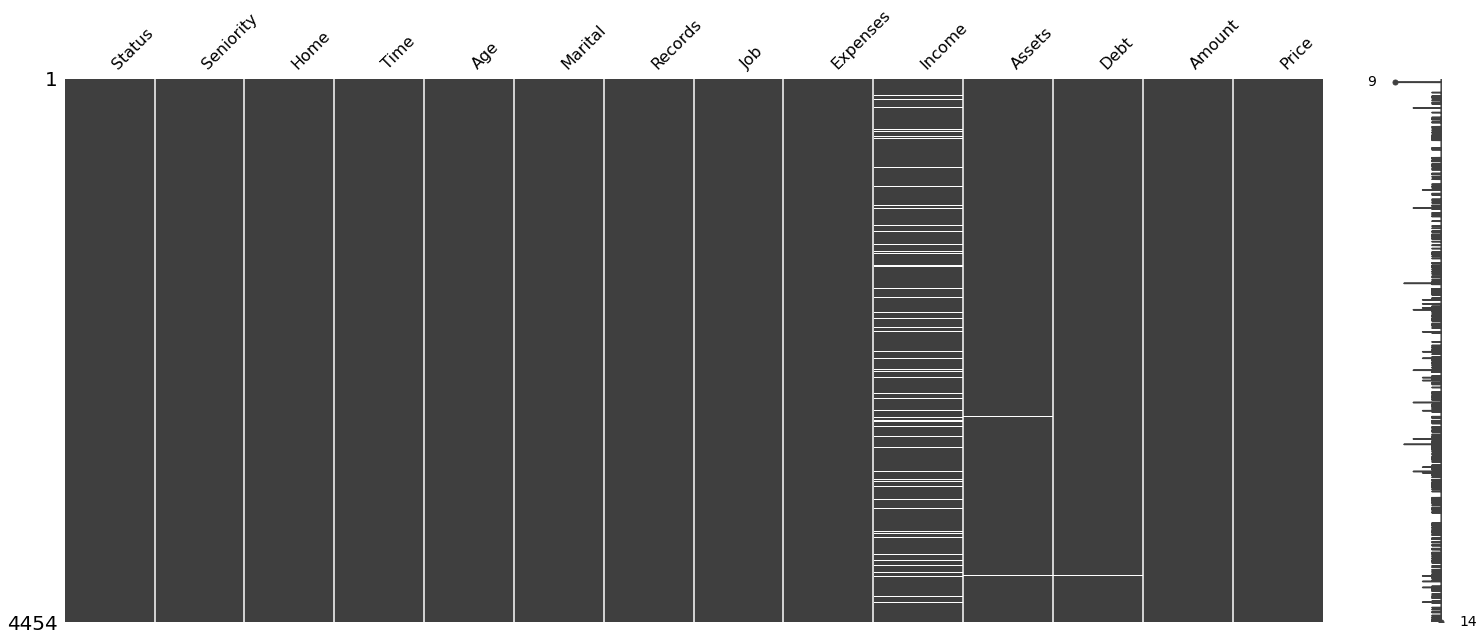

In [3]:
#Checking for Missing Values
miss.matrix(credit)

(Question 2) In order to understand the missing values present in the current, I took a look at how the data was originally put together. If we go to the github page originally linked in the the problem set, we can see that the authors of this dataset coded the NAs in the following way:
```
# codify missing values as NA
income[income == 99999999 | income == 0] <- NA
assets[assets == 99999999] <- NA
debt[debt == 99999999] <- NA
```
I personally checked this information by downloading the original dataset ('CreditScoring.csv') from the github and found that anywhere where the value was 0 or 999,999 was coded into NA for the 'credit_data.csv' dataset.

The original authors of the dataset used kNN imputation to handle the missing values. Since we haven't learned that specific skill, for the purposes of this exercise, I feel comfortable in just dropping the NA values. Once we remove the NA values we go from 4454 rows to 4039 rows.

In [4]:
#Dropped all missing values
credit = credit[~credit.isna().any(axis=1)]

Because I know I'm going to be making changes to my data I decided to split the data after said changes rather than before like the problem set wanted.

#### Pre Split Examination - Continuous (Int)

In [5]:
#Checked the datatype of the dataset
credit.dtypes

Status        object
Seniority      int64
Home          object
Time           int64
Age            int64
Marital       object
Records       object
Job           object
Expenses       int64
Income       float64
Assets       float64
Debt         float64
Amount         int64
Price          int64
dtype: object

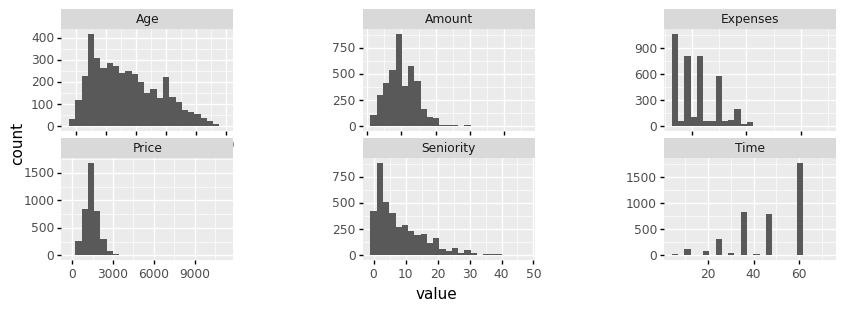

<ggplot: (271865863)>

In [6]:
# Plotted the Continuous Variables (int)
d = credit.select_dtypes(include="int").melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins = 25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.75})
)

(Question 2) At first glance the *Expenses* and *Time* plots look a little strange. But, when running `(set(credit['Time']))` we can quickly see that *Time* has already been categorized.

*Expenses* is a much stranger graph and seems to be a good candidate for rebinning the data rather than a log transformation along with *Seniority*. *Amount* and *Price* seem to be the best candidates for a log transformation.

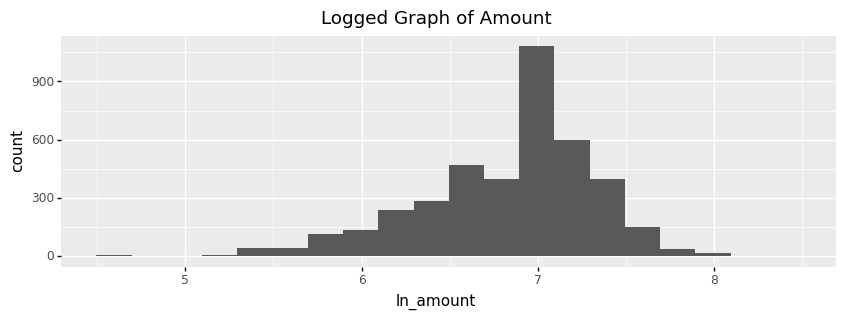

<ggplot: (271866013)>

In [7]:
#Plotted the log transformation of the Amount column
d = credit.copy()
d['ln_amount'] =  np.log(d['Amount'] + 1)
(
    ggplot(d,aes(x="ln_amount")) +
    geom_histogram(bins = 20) +
    ggtitle ("Logged Graph of Amount") +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

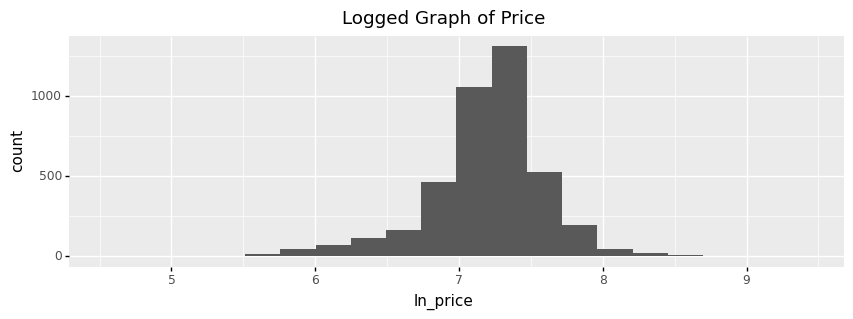

<ggplot: (306128493)>

In [8]:
#Plotted the log transformation of the Price column
d['ln_price'] =  np.log(d['Price'] + 1)
(
    ggplot(d,aes(x="ln_price")) +
    geom_histogram(bins = 20) +
    ggtitle ("Logged Graph of Price") +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

##### Amount

In [9]:
#Logged Amount and created a new column for that value
credit['ln_amount'] =  np.log(credit['Amount'])

#Dropped the original Amount column
credit = credit.drop(['Amount'],axis=1)

##### Expense

In [10]:
#Rebinned Expense into 5 bins
credit['Expenses'] = pd.cut(credit['Expenses'], 4, labels = ["0", "1", "2", "3"])

In [11]:
#Changed the Expense data type
credit['Expenses'] = credit['Expenses'].astype(float)

##### Price

In [12]:
#Logged Price and created a new column for that value
credit['ln_price'] =  np.log(credit['Price'])

#Dropped the original Price column
credit = credit.drop(['Price'],axis=1)

##### Seniority

In [13]:
#Rebinned Seniority into 5 bins
credit['Seniority'] = pd.qcut(credit['Seniority'], q=6, labels = list(map(str, np.arange(6))), precision = 0)

In [14]:
#Changed the Seniority data type
credit['Seniority'] = credit['Seniority'].astype(float)

#### Pre Split Examination - Continuous (Float)

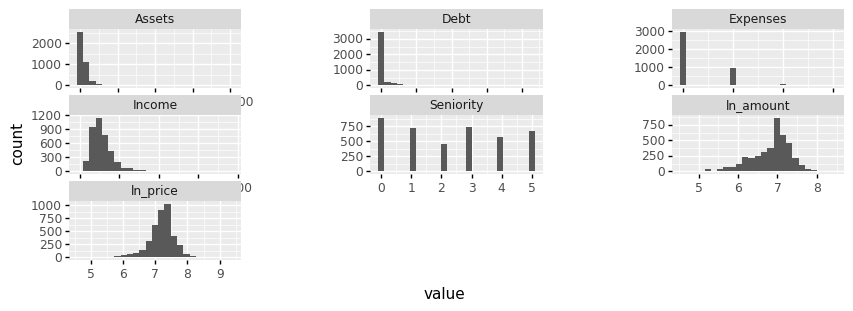

<ggplot: (305839803)>

In [15]:
# Plotted the Continuous Variables (float)
d = credit.select_dtypes(include="float").melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins = 25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.75})
)

(Question 2) Given that *Assets* and *Debt* scale is vastly different from the other variables, I think rescaling these two values makes a lot of sense. *Income*, on the other hand, appears to be a good candidate for a log transformation.

##### Income

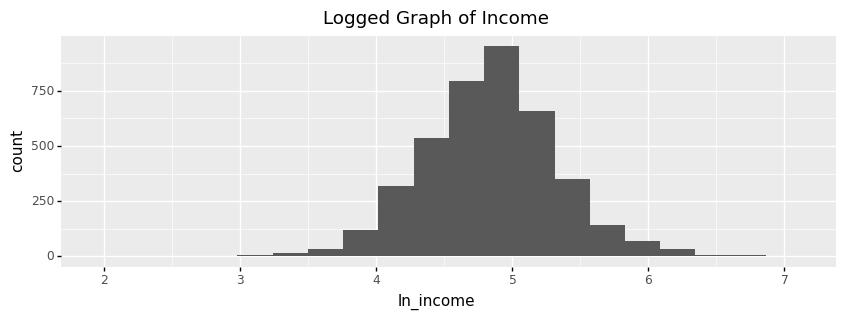

<ggplot: (306065415)>

In [16]:
#Plotted the log transformation of the Income column
d = credit.copy()
d['ln_income'] =  np.log(d['Income'] + 1)
(
    ggplot(d,aes(x="ln_income")) +
    geom_histogram(bins = 20) +
    ggtitle ("Logged Graph of Income") +
    theme(figure_size=(10,3),
          subplots_adjust={'wspace':0.25})
)

In [17]:
#Logged Income and created a new column for that value
credit['ln_income'] =  np.log(credit['Income'])

#Dropped the original Amount column
credit = credit.drop(['Income'],axis=1)

#### Pre Split Examination - Categorical to Numerical Variables

In [18]:
#Checked the datatype of the dataset
credit.dtypes

Status        object
Seniority    float64
Home          object
Time           int64
Age            int64
Marital       object
Records       object
Job           object
Expenses     float64
Assets       float64
Debt         float64
ln_amount    float64
ln_price     float64
ln_income    float64
dtype: object

In [19]:
#Converted categorical variables to categories
for col in ['Status', 'Home', 'Marital', 'Records', 'Job']:
    credit[col] = credit[col].astype('category')

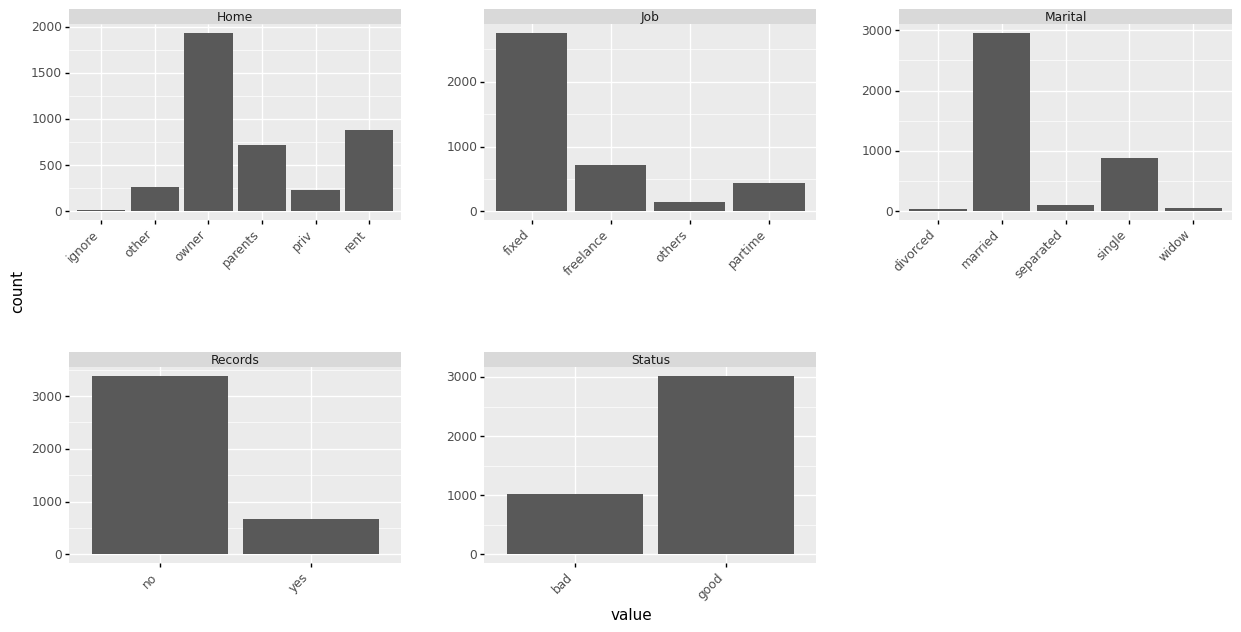

<ggplot: (306874658)>

In [20]:
#Plotted the categorical predictors to determine if any changes need to be made
d = credit.select_dtypes(include="category").melt()
(
    ggplot(d,aes(x="value")) +
    geom_bar() +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(15,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

(Question 2) Based on the bar graphs above it makes sense to tranforms these categories into numerical values for easier analysis.

##### Status

In [21]:
#Converted Status into a dummy variable
credit['Status'].value_counts()

good    3013
bad     1026
Name: Status, dtype: int64

In [22]:
#Assigned a value of 1 for 'good'
credit['Status'] = 1*(credit['Status'] == "good")

In [23]:
#Checked the new value
credit['Status'].sum()

3013

##### Records

In [24]:
#Converted Record into a dummy variable
credit['Records'].value_counts()

no     3377
yes     662
Name: Records, dtype: int64

In [25]:
#Assigned a value of 1 for 'yes'
credit['Records'] = 1*(credit['Records'] == "yes")

In [26]:
#Checked the new value
credit['Records'].sum()

662

(Question 2) For the last three categories (*Home*, *Job*, and *Marital*), I think it would make sense to collapse the data and lower the bin size given that some values have very little representation in the dataset.

##### Home

In [27]:
#Collapsed Home into 3 values
credit['Home'].value_counts()

owner      1930
rent        883
parents     721
other       259
priv        227
ignore       19
Name: Home, dtype: int64

In [28]:
#Got dummy values for the Home column
home_dummies = pd.get_dummies(credit.Home)

#Dropped 'ignore', 'other', and 'priv' to set our baseline
home_dummies = home_dummies.drop(['ignore', 'other', 'priv'],axis=1)

#Capitalized the dummy column
home_dummies.columns = ['Owner', 'Parents', 'Rent']

In [29]:
#Concatted the new home dummy values to the dataframe while dropping the Home column
credit = pd.concat([credit.drop(['Home'],axis=1),home_dummies],axis=1)

##### Job

(Question 2) Since both *Freelance* and *Partime* are so close in count, I think it would be worth exploring if there is a difference in *Status* value for both of these job categories.

If there isn't a difference in *Status* for both of these job categories, I would feel comfortable grouping *Freelance* and *Partime* together. If not, I would leave the job categories as *Fixed*, *Freelance*, *Partime*, and *Other*.

In [30]:
#Created a freelance only dataframe to visualize
freelance = credit[(credit['Job'] == "freelance")]

#Created a partime only dataframe to visualize
partime = credit[(credit['Job'] == "partime")]

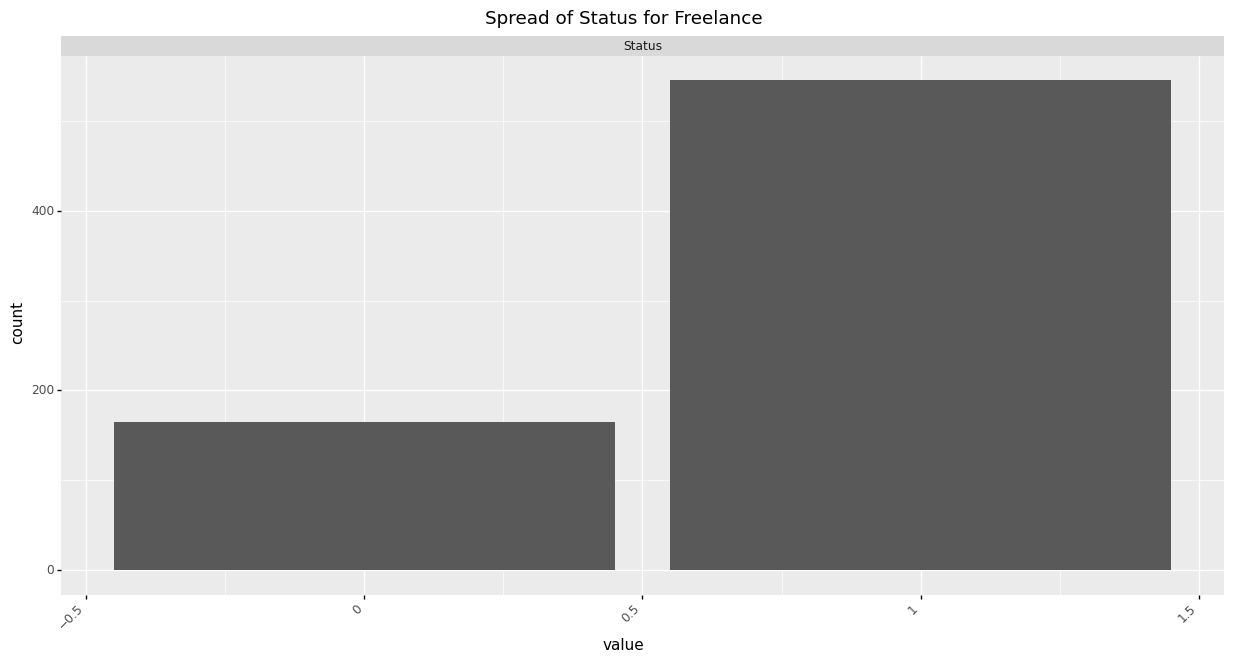

<ggplot: (306885253)>

In [31]:
#Plotted the spread of the Status values for freelance
d = freelance.melt(value_vars=['Status'])
(
    ggplot(d,aes(x="value")) +
    geom_bar() +
    facet_wrap("variable",scales='free') +
    ggtitle ("Spread of Status for Freelance") +
    theme(figure_size=(15,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

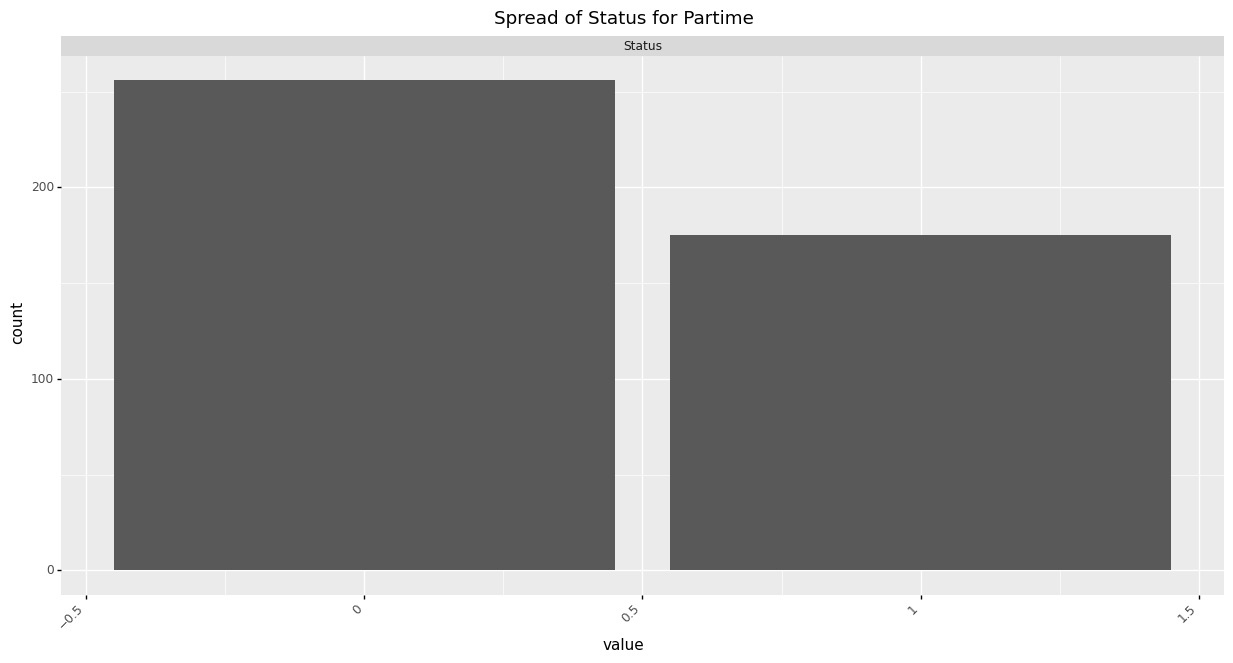

<ggplot: (306186319)>

In [32]:
#Plotted the spread of the Status values for partime
d = partime.melt(value_vars=['Status'])
(
    ggplot(d,aes(x="value")) +
    geom_bar() +
    facet_wrap("variable",scales='free') +
    ggtitle ("Spread of Status for Partime") +
    theme(figure_size=(15,7),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

In [33]:
#Collapsed Jobs into 4 values
credit['Job'].value_counts()

fixed        2751
freelance     710
partime       431
others        147
Name: Job, dtype: int64

In [34]:
#Got dummy values for the Job column
job_dummies = pd.get_dummies(credit.Job)

#Dropped 'others' to set our baseline
job_dummies = job_dummies.drop(['others'],axis=1)

#Capitalized the dummy column
job_dummies.columns = ['Fixed', 'Freelance', 'Parttime']

In [35]:
#Concatted the new job dummy columns to the dataframe while dropping the Home column
credit = pd.concat([credit.drop(['Job'],axis=1),job_dummies],axis=1)

##### Marital

In [36]:
#Collapsed Jobs into 4 values
credit['Marital'].value_counts()

married      2950
single        881
separated     112
widow          62
divorced       34
Name: Marital, dtype: int64

In [37]:
#Got dummy values for the Marital column
mar_dummies = pd.get_dummies(credit.Marital)

#Dropped 'divorced', 'separated', 'widow' to set our baseline
mar_dummies = mar_dummies.drop(['divorced', 'separated', 'widow'],axis=1)

#Capitalized the dummy column
mar_dummies.columns = ['Married', 'Single']

In [38]:
#Concatted the new marital dummy columns to the dataframe while dropping the Marital column
credit = pd.concat([credit.drop(['Marital'],axis=1),mar_dummies],axis=1)

#### Splitting the Data

In [39]:
#Split the data into test and training data
y = credit[['Status']]
X = credit.drop(columns=['Status'])
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

In [41]:
train_y.dtypes

Status    int64
dtype: object

In [40]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=202011)

#### Hyperparameters

##### KNN

In [41]:
#Created an array of all possible options
options = np.arange(2422)

In [42]:
#Passed a dictionary of all the tuning parameter values that we want to explore
knn_tune_params = {'n_neighbors':options}

In [43]:
#Wrapped the model method in the GridSearchCV() class
tune_knn = GridSearchCV(KNN(),knn_tune_params,
                        cv = fold_generator,
                        scoring='roc_auc',
                        n_jobs=4)

In [44]:
#Tunned KNN
tune_knn.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=202011, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid={'n_neighbors': array([   0,    1,    2, ..., 2419, 2420, 2421])},
             scoring='roc_auc')

In [45]:
#Best number of neighbors
tune_knn.best_params_

{'n_neighbors': 308}

##### Decision Tree

So I originally ran the below code in different increments (i.e. 0-100, 100-250, 250 - 1000, etc.) and got a pretty varied assortment of numbers as the "best" so I decided to use all of them in the search_space.

In [46]:
#Wrapped the model method in the GridSearchCV() class
tune_dt = GridSearchCV(DT_reg(),{'max_depth':[i for i in range(0,100)]},
                        cv = fold_generator,
                        scoring='roc_auc',
                        n_jobs=5)

In [47]:
#Tunned the Decision Tree
tune_dt.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=202011, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=5,
             param_grid={'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, ...]},
             scoring='roc_auc')

In [48]:
#Best tree depth size
tune_dt.best_params_

{'max_depth': 5}

##### Random Forest

In [49]:
#Wrapped the model method in the GridSearchCV() class
rf_params = {'max_depth':[11, 12, 13, 14, 15],
             'n_estimators':[1000],
              'max_features': [1,2,3]} # Only have three total.
tune_rf = GridSearchCV(RF(),rf_params,
                        cv = fold_generator,
                        scoring='roc_auc',
                        n_jobs=4)

In [50]:
#Tuned random forest
tune_rf.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=202011, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': [11, 12, 13, 14, 15],
                         'max_features': [1, 2, 3], 'n_estimators': [1000]},
             scoring='roc_auc')

In [51]:
#Best parameters for random forest
tune_rf.best_params_

{'max_depth': 15, 'max_features': 2, 'n_estimators': 1000}

#### Model

In [52]:
#Created the model pipeline
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

In [53]:
#Search space utilizing the best parameters from above
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[20, 24, 30, 37, 42, 50, 153]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[5, 151, 278, 337, 464, 505, 601, 736, 806, 990, 1052, 3126, 8662]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[5, 9, 13],
    'model__n_estimators':[i for i in range(0,1000,100)],
    'model__max_features':[1, 2, 3]}
    
]

In [54]:
#Gridsearch
search = GridSearchCV(pipe, search_space,
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

In [55]:
#Ran the search
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=202011, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [20, 24, 30, 37, 42, 50, 153]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [5, 151, 278, 337, 464, 505, 601,
                                               736, 806, 990, 1052, 3126,
                                               8662]},
                         {'model': [RandomForestClassifier(max_depth=13,
                                                           max_features=2,
                                                           n_estimators=900)],
                          'model__max_depth': [5, 9, 13],
                          '

In [56]:
#Best score
search.best_score_

0.8325148381338844

In [57]:
#Best parameters
search.best_params_

{'model': RandomForestClassifier(max_depth=13, max_features=2, n_estimators=900),
 'model__max_depth': 13,
 'model__max_features': 2,
 'model__n_estimators': 900}

In [58]:
#Labelled the best model
rf_mod = search.best_estimator_

#### Performance

In [59]:
#ROC Score
m.roc_auc_score(train_y,rf_mod.predict_proba(train_X)[:,1])

0.9985406268415831

In [60]:
#Accuracy
m.accuracy_score(train_y,rf_mod.predict(train_X))

0.9646748101683724

(Question 5) The model that performed the best using the area under the ROC curve (AUC) metric was the random forest model using a tree depth of 13, "growing" 900 trees and using 2 variables.

The accuracy of this specific model is 0.9646: this means that the RF correctly predicted *Status* about 96.27% of the time. The true positive and false positive rate of this model is at 0.998 which is an insanely good score and shows that the model is much better than what we would expect from a random classifier.

#### Permutation Importance

In [61]:
#Permuted the features to determine importance
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=100)

In [62]:
# Organize as a data frame
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)

In [63]:
#Outputted the results
vi_dat

,variable,vi,std,low,high
0,Records,0.068237,0.002533,0.063171,0.073303
1,ln_income,0.064718,0.002975,0.058768,0.070668
2,Seniority,0.061370,0.003209,0.054951,0.067789
3,Assets,0.058336,0.002978,0.052380,0.064292
4,ln_amount,0.058032,0.002462,0.053108,0.062956
5,Age,0.042136,0.001694,0.038748,0.045524
6,ln_price,0.041875,0.001780,0.038315,0.045436
7,Time,0.036428,0.002717,0.030994,0.041862
8,Owner,0.031152,0.002442,0.026268,0.036036
9,Fixed,0.029059,0.002176,0.024707,0.033411


(Question 6) The three variables the model relies the on most when making predictions are *Records*, *ln_income*, and *Seniority*.

#### Partial Dependency Plots

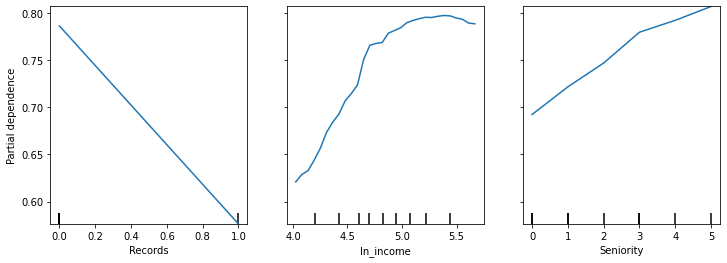

In [64]:
# Target specific features
features = ['Records','ln_income','Seniority']

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(12, 4))
display = plot_partial_dependence(
    rf_mod, train_X, features,n_cols=5,
    n_jobs=4, grid_resolution=30,ax=ax
)

(Question 6)
* *Records* - Given that *Records* is a binomial relationships (only resulting in two states) it makes sense that the presence of records leads to a decrease in the average "probability" (likelihood perhaps?) of good credit. This would be classified as a linear relationship.

* *ln_income* - There appears to be a logarithmic relationship between *ln_income* and the average "probability" of good credit. It appears that good credit seems to plateau at a specific logged income level and this makes sense given that good credit and being rich are interrelated.

* *Seniority* - Given that I equally binned out the *Seniority* categories, a one bin increase (say going from 0 to 1) translates to an actual difference in work experience. This relationship appears to be linear with a slight pivot in between the 2nd and 3rd bin. The more work experience you have, on average, the more likely you are to have good credit.

One thing I want to note is that I do understand that y-axis does not represent probability but the two state of *Status*: 1 and 0. I couldn't think of how else to describe this relationship so I used "probability".

#### ICE Plots

Although the problem set asks for an ICE plot of the most important variable I decided to plot the second most important variable, *ln_income*. I did this because *Records* is only 2 values and the actual difference of importance between *Records* and *ln_income* is less than 0.01.

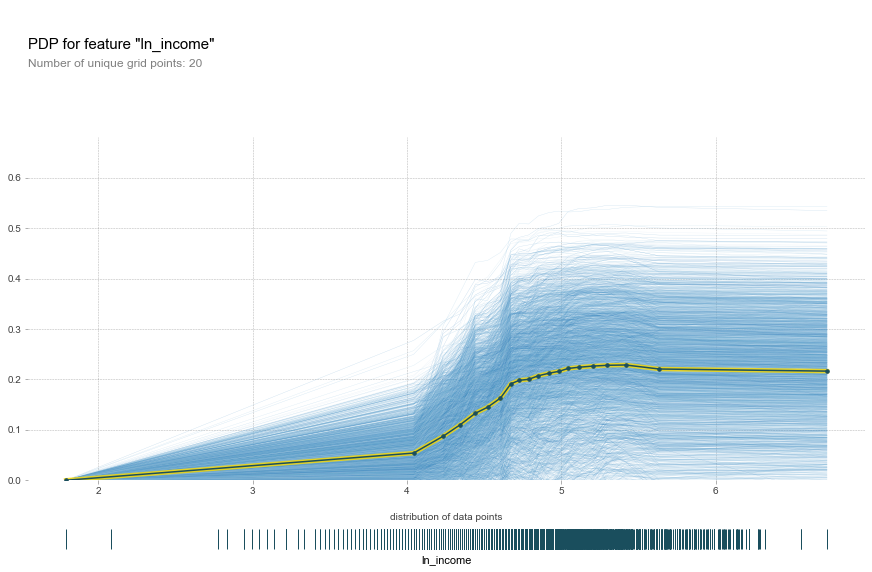

In [65]:
#ICE Plot for the variable of interest
pdp_dist = pdp.pdp_isolate(model = rf_mod,
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="ln_income",num_grid_points = 20)

fig,ax = pdp.pdp_plot(pdp_dist,'ln_income',plot_pts_dist = True,
                      center = True, plot_lines = True, # ICE part                       
                      figsize = (15,10))

(Question 6) So right from the get go, there appears to be a lot of heterogeneity with this dataset; the most pronounced of which happening at the first pivot (tick number 4). This essentially means that there is an interaction with a different variable at play here (perhaps *Records* or *Seniority*) that is contributing to the spread of the data.

(Question 7) One hypothesis, or idea that I would like to explore, is the interplay of *ln_income* and the existance of *Records* on credit scores. The ML data seems to show that *Records* is an incredibly strong factor when determing if an individual has good or bad credit.

And, common knowledge, tells us that people with more money are more likely to have good credit as they would be able to consistantly pay their credit card bills. Couple this with the fact that declaring bankrupcy hurts the poor way more than the rich (https://www.ovlg.com/education/rich-vs-poor-who-suffers-and-who-enjoys-in-bankruptcy.html) this begs the question: at what income level does the negative effects of the existance of records stop affecting a person's credit score? And more broadly are there certain records (criminal, bankrupcy, etc.) that have a stronger effect on an individual's credit score than others?

I think, in order to parse this question through, one of the first steps to take would be to take a look at those who have records but still maintain good credit. I would hypothesize that those individuals are of a high income bracket but are there any other factor that is common amongst all of them? Would it be *Seniority* or possibly ownership of their house? Alternatively I think it would be worthwhile to look at those who are the opposite of this as well: people who don't have records but have bad credit. What are the common factors amongst those people? I think looking at these extremes first will provide either evidence supporting or negating my hypothesis.